<center><h1> - Tabular Playground Series - Sep 2022 - </h1></center>
<b>Goal</b>: Predicting book sales during the year 2021 for 4 items from two competing stores located in six different countries.

### ⬇ Libraries

In [141]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

💡 <b> Insights from data exploration </b>
- Data after 2020 is intrinsically different from the years before. Therefore, I tend to not include it in the model.
- Include time dependency as some sort of cosine or sine function is essential at least for ANN's, RNN's but less for CNN's
- The country does not have any influence after 2020.
- Sales in the two store differ only by a constant factor.


<b> Things to test: </b>
- Use only data from 2020 onward
- Use only data from before
- Mix data (But I don't think this will lead to any good results as distribution is totally different?)

<b> Things to keep in mind </b>
- Remove last day in Feb. of leap year

### Folders

In [142]:
PROJECT_DIR = os.path.join(".", "..")
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")

### Hyperparameters

In [143]:
# Amount of rows we have per day
ROWS_PER_DAY  = 4 * 2 * 6
DAYS_PER_WEEK = 7
# Leap year day will be ignored as we only predict data for 2021
DAYS_PER_YEAR = 365 

### Load dataset

In [144]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIR, "test.csv"))
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

### Drop Leap year day

In [145]:
print("Before dropping training data shape is: ", train_df.shape)
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df
print("After dropping training data shape is: ", train_df.shape)

Before dropping training data shape is:  (70128, 6)
After dropping training data shape is:  (70080, 6)


In [146]:
train_df.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [147]:
test_df.head()

,row_id,date,country,store,product
0,70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
1,70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
2,70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
3,70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
4,70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


### Add weekly and yearly seasonality information

In [182]:
# Note: As weeks don't end after 1 year it is important to count the day indices from the 
# beginning of the train all the way to the end of the test set.
day_indices = np.array([i // ROWS_PER_DAY for i in range(0, len(train_df) + len(test_df))])
# Seperate indices
day_indices_train = day_indices[:len(train_df)]
day_indices_test = day_indices[len(train_df):]

#day_indices_test = np.array([i // ROWS_PER_DAY for i in range(0, len(test_df))])
assert len(day_indices_train) == train_df.shape[0]
assert len(day_indices_test) == test_df.shape[0]

In [183]:
# Add seasonality information as sine & cosine to train & test dataset
# Note: Substract 1 as we start counting from 0
train_df['week_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['week_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
train_df['year_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))
train_df['year_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))

test_df['week_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['week_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
test_df['year_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))
test_df['year_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))

### Plot result

<b> Note: </b> 
- It is clear that the indices are correct as the week cycle continues in the test set

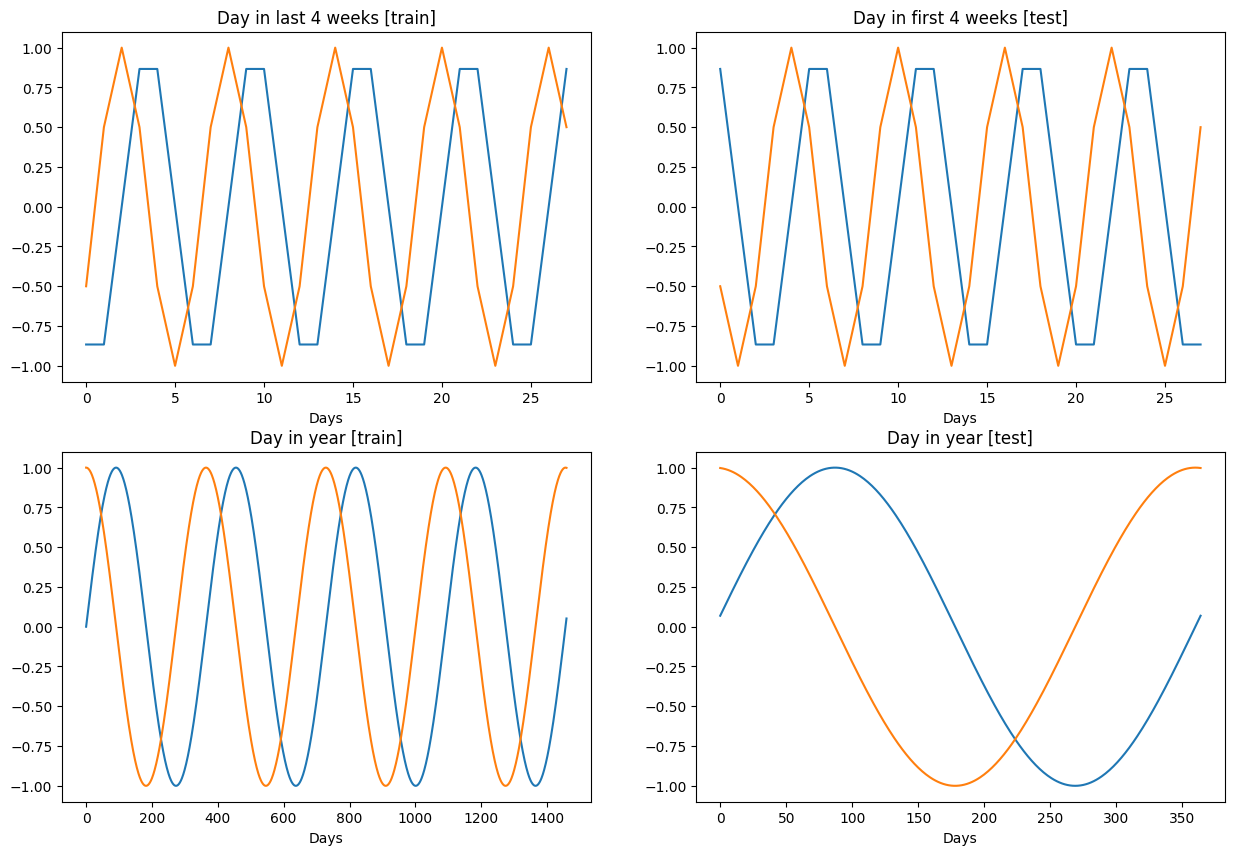

In [187]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df['week_sin'])[::ROWS_PER_DAY][-28:])
axes[0][0].plot(np.array(train_df['week_cos'])[::ROWS_PER_DAY][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df['week_sin'])[::ROWS_PER_DAY][:28])
axes[0][1].plot(np.array(test_df['week_cos'])[::ROWS_PER_DAY][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df['year_sin'])[::ROWS_PER_DAY])
axes[1][0].plot(np.array(train_df['year_cos'])[::ROWS_PER_DAY])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df['year_sin'])[::ROWS_PER_DAY])
axes[1][1].plot(np.array(test_df['year_cos'])[::ROWS_PER_DAY])

## 💡 Idea 1
- Data distribution in years before 2020 is different to 2020. 
- Assuming that the year 2021 will be similar to 2020 as COVID was still active let's focus on the year 2020 as training data.
- In the year 2020 we saw that the country does <b> not </b> have any impact on the sales. What does matter is the store and the product.
- We also learned from EDA that the daily per product sales are reasonably identical across the two shops. Therefore, by multiplying the Rama store sales by `2.88` we obatin the Mart store sales.
- To conclude let's
    - use data for later than 01.01.2020
    - average the sales over the country
    - multiply Rama store by `2.885` & average per product = normalise both and average per product.

### Use data later than 01.01.2020 for training

In [188]:
train_df_prep = train_df[train_df["date"] >= pd.Timestamp("2020-01-01")]
test_df_prep = test_df.copy(deep = True)

### Average sales over country

In [189]:
train_df_prep = train_df_prep.groupby(['date','store','product']).agg({
    'num_sold': 'mean',
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

test_df_prep = test_df_prep.groupby(['date','store','product']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

In [190]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [191]:
test_df_prep.head()

,date,store,product,year_cos,year_sin,week_sin,week_cos
0,2021-01-01,KaggleMart,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5
1,2021-01-01,KaggleMart,Kaggle Getting Started,0.997617,0.068991,0.866025,-0.5
2,2021-01-01,KaggleMart,Kaggle Recipe Book,0.997617,0.068991,0.866025,-0.5
3,2021-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,0.997617,0.068991,0.866025,-0.5
4,2021-01-01,KaggleRama,Kaggle Advanced Techniques,0.997617,0.068991,0.866025,-0.5


#### Plot to make sure the week cycles align

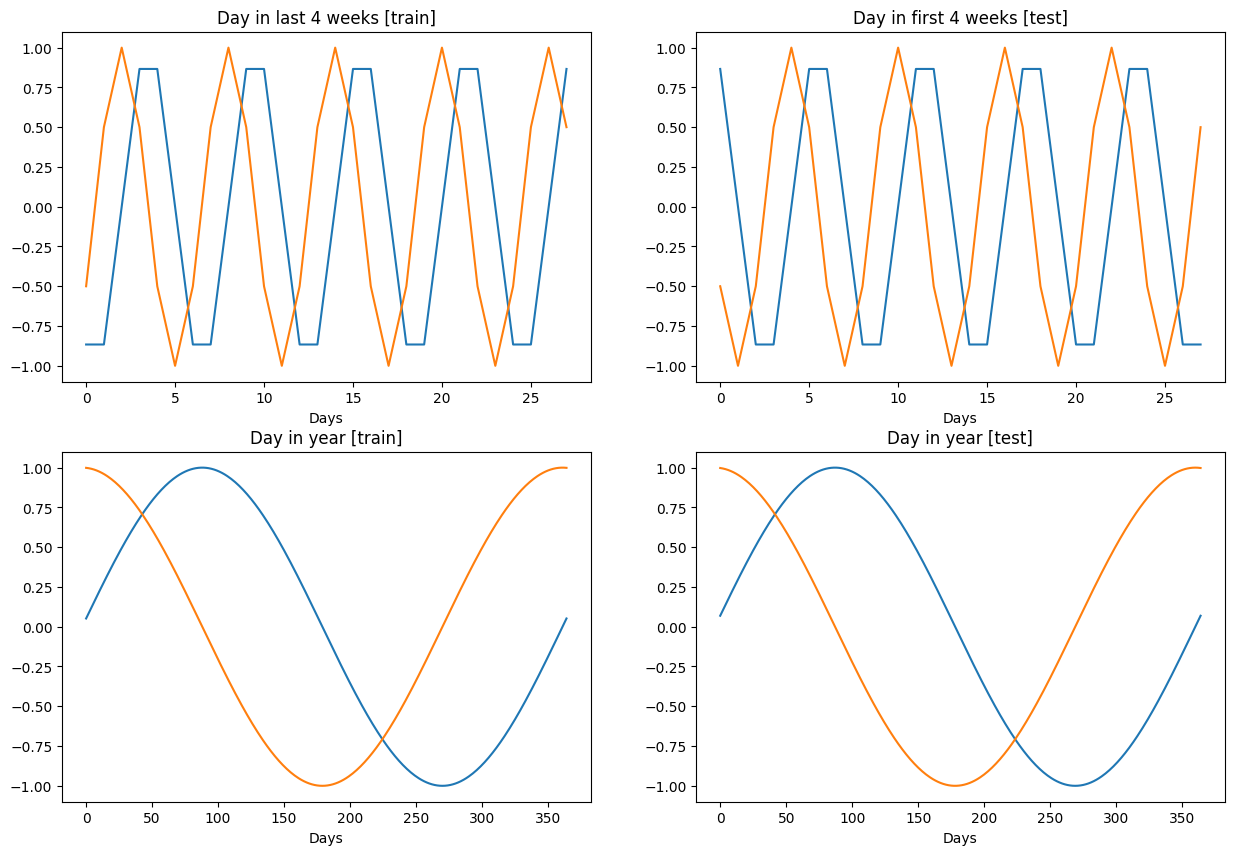

In [193]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df_prep['week_sin'])[::8][-28:])
axes[0][0].plot(np.array(train_df_prep['week_cos'])[::8][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df_prep['week_sin'])[::8][:28])
axes[0][1].plot(np.array(test_df_prep['week_cos'])[::8][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df_prep['year_sin'])[::8])
axes[1][0].plot(np.array(train_df_prep['year_cos'])[::8])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df_prep['year_sin'])[::8])
axes[1][1].plot(np.array(test_df_prep['year_cos'])[::8])

### Multiply Rama store by `2.885` & average per product.

#### Plot beforehand

In [194]:
train_df_prep.head()

,date,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
0,2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
1,2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2,2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
3,2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
4,2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [224]:
tmp_df = train_df_prep.copy(deep=True)

In [225]:
tmp_df.set_index('date', inplace=True)

In [226]:
rama_sold = tmp_df[tmp_df["store"] == "KaggleRama"]["num_sold"]
rama_sold *= 2.885

In [227]:
tmp_df[tmp_df['store'] == 'KaggleRama']['num_sold'] = rama_sold

/var/folders/v_/b5t6_0vj0_10k224shdsj6tw0000gn/T/ipykernel_61017/3307352036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df[tmp_df['store'] == 'KaggleRama']['num_sold'] = rama_sold


In [228]:
tmp_df.head()

,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
date,,,,,,,
2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


In [229]:
tmp_df.head()

,store,product,num_sold,year_cos,year_sin,week_sin,week_cos
date,,,,,,,
2020-01-01,KaggleMart,Kaggle Advanced Techniques,387.166667,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle Getting Started,321.166667,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle Recipe Book,274.500000,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleMart,Kaggle for Kids: One Smart Goose,427.000000,0.998659,0.051761,1.832554e-13,-1.0
2020-01-01,KaggleRama,Kaggle Advanced Techniques,133.166667,0.998659,0.051761,1.832554e-13,-1.0


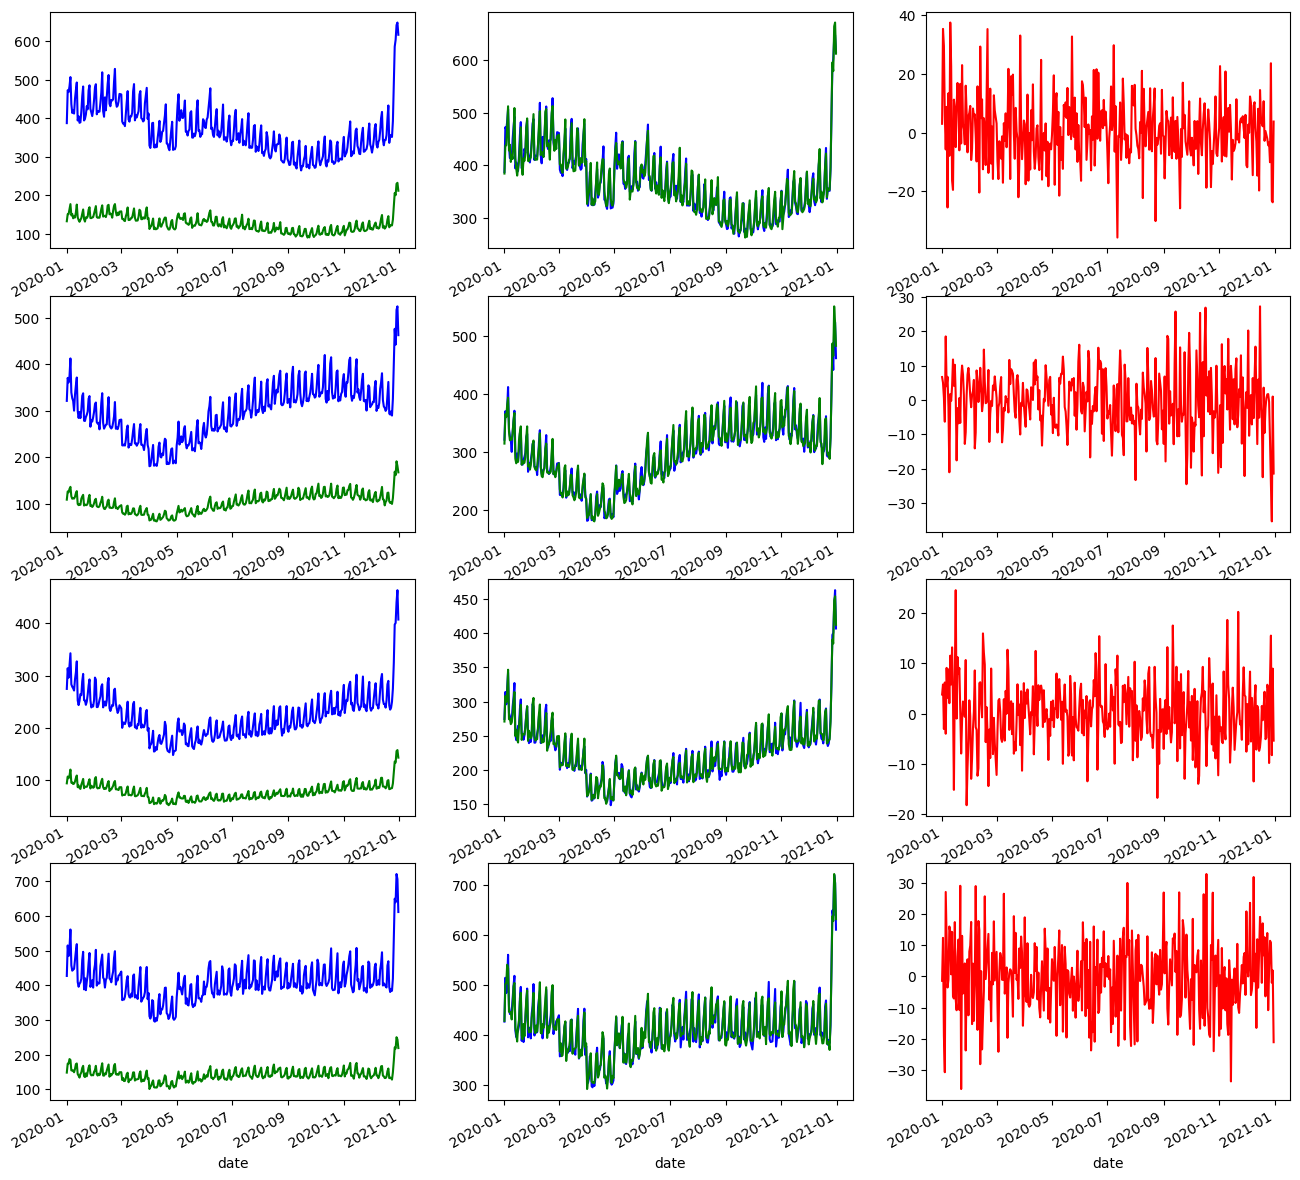

In [232]:
# Map each store to a color
store_to_color = {
    'KaggleMart': 'b',
    'KaggleRama': 'g',
}
# Configure subplot 
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,16))

for idx, product in enumerate(train_df_prep["product"].unique()):
    # Define index and col for subplot
    if idx <= 3:
        row = idx 
    else:
        row = idx - 4

    tmp_df = train_df_prep[train_df_prep["product"] == product].copy(deep=True)
    tmp_df.set_index('date', inplace=True)
    for store in train_df_prep["store"].unique():
        tmp_df[tmp_df['store'] == store]['num_sold'].plot(label=store, c = store_to_color[store], ax = axes[row][0])

    # Plot with adjusted num_sold
    for store in train_df_prep["store"].unique():
        if store == "KaggleRama":
            num_sold = tmp_df[tmp_df['store'] == store]['num_sold'] * 2.885
            num_sold.plot(label=store, c = store_to_color[store], ax = axes[row][1])
        else:
            tmp_df[tmp_df['store'] == store]['num_sold'].plot(label=store, c = store_to_color[store], ax = axes[row][1])

    # Plot Error between values
    num_sold_mart = tmp_df[tmp_df['store'] == "KaggleMart"]['num_sold']
    adjusted_num_sold_rama = tmp_df[tmp_df['store'] == "KaggleRama"]['num_sold'] * 2.885
    (num_sold_mart - adjusted_num_sold_rama).plot(label=store, c = 'r', ax = axes[row][2])

In [ ]:

for idx, fused_combination in enumerate(store_product_df.fused.unique()):
    col = idx // 4
    if idx <= 3:
        row = idx 
    else:
        row = idx - 4

    axes[row][col].set_title(fused_combination)
    axes[row][col].set_xlabel('Lag')
    pd.plotting.autocorrelation_plot(store_product_df[store_product_df['fused'] == fused_combination]['num_sold'], ax=axes[row][col])


In [ ]:


plt.figure(figsize=(16, 8), dpi=150)
for store in train_df_prep.store.unique():
    
for fused_combination in store_product_df.fused.unique():
    store_product_df[store_product_df['fused'] == fused_combination]['num_sold'].plot(label=fused_combination, c = store_to_color[fused_combination])
#plt.legend()
plt.title("Sales per country, store & product")
plt.xlabel("date")
plt.show()